/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda

***** Experiment 1: Standard Training *****

Running experiment on Thermal dataset with SegNet.
Thermal dataset loaded: 636 images, 6 classes.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 196MB/s]



Epoch 1/10
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.6650  Acc: 0.3255
Val Loss: 1.5753  Acc: 0.3780
--------------------------------------------------

Epoch 2/10
--------------------------------------------------
Train Loss: 1.4349  Acc: 0.4304
Val Loss: 1.3596  Acc: 0.5197
--------------------------------------------------

Epoch 3/10
--------------------------------------------------
Train Loss: 1.2081  Acc: 0.5643
Val Loss: 1.0923  Acc: 0.5748
--------------------------------------------------

Epoch 4/10
--------------------------------------------------
Train Loss: 1.0012  Acc: 0.6483
Val Loss: 0.8413  Acc: 0.6299
--------------------------------------------------

Epoch 5/10
--------------------------------------------------
Train Loss: 0.8012  Acc: 0.6798
Val Loss: 0.5600  Acc: 0.7795
--------------------------------------------------

Epoch 6/10
--------------------------------------------------
Train Loss: 0.6688  Acc: 0.7585
Val Loss: 0.5818  Acc: 0.7795
--------------------------------------------------

Epoch 

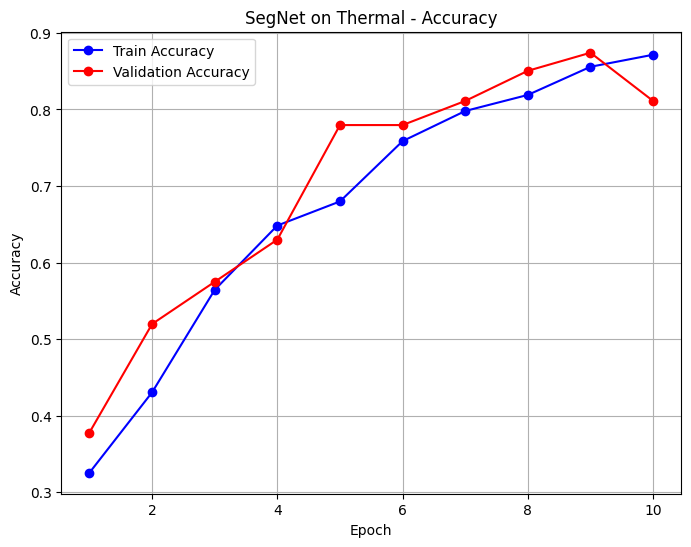

Test Accuracy: 0.7969


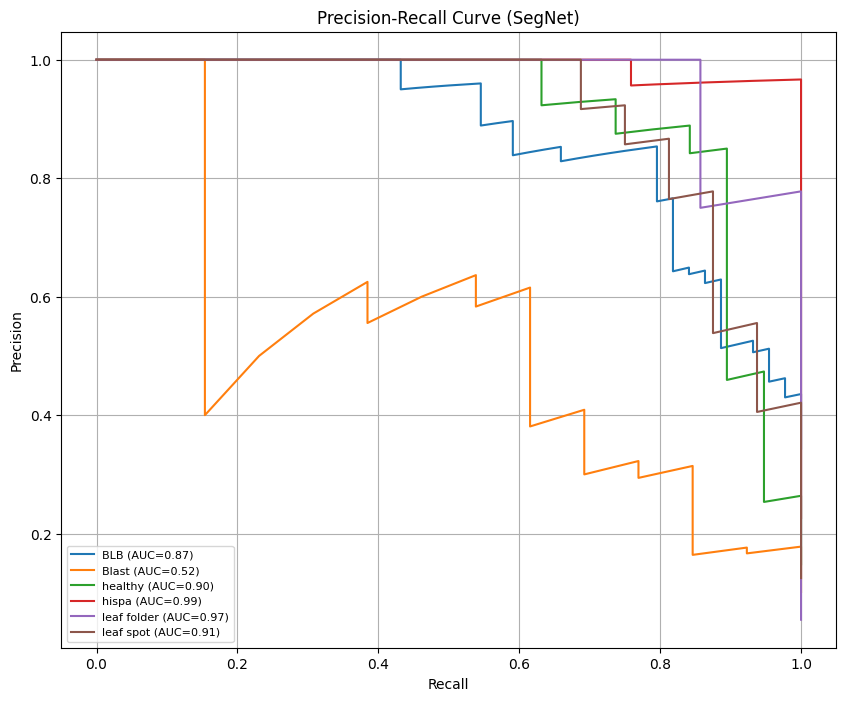

Final test accuracy for SegNet on Thermal: 0.7969


***** Experiment 2: Augmented Thermal Dataset *****
Augmenting Thermal dataset to balance classes...
Class hispa: augmented to 220 images.
Class leaf folder: augmented to 220 images.
Class BLB: augmented to 220 images.
Class Blast: augmented to 220 images.
Class healthy: augmented to 220 images.
Class leaf spot: augmented to 220 images.

Running experiment on Thermal dataset with SegNet.
Thermal dataset loaded: 1320 images, 6 classes.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.5697  Acc: 0.3813
Val Loss: 1.0850  Acc: 0.6288
--------------------------------------------------

Epoch 2/10
--------------------------------------------------
Train Loss: 0.9749  Acc: 0.6086
Val Loss: 0.4557  Acc: 0.8333
--------------------------------------------------

Epoch 3/10
--------------------------------------------------
Train Loss: 0.6749  Acc: 0.7500
Val Loss: 0.5738  Acc: 0.7955
--------------------------------------------------

Epoch 4/10
--------------------------------------------------
Train Loss: 0.5673  Acc: 0.8043
Val Loss: 0.3890  Acc: 0.8636
--------------------------------------------------

Epoch 5/10
--------------------------------------------------
Train Loss: 0.3978  Acc: 0.8485
Val Loss: 0.4627  Acc: 0.8333
--------------------------------------------------

Epoch 6/10
--------------------------------------------------
Train Loss: 0.3614  Acc: 0.8737
Val Loss: 0.2789  Acc: 0.9129
--------------------------------------------------

Epoch 

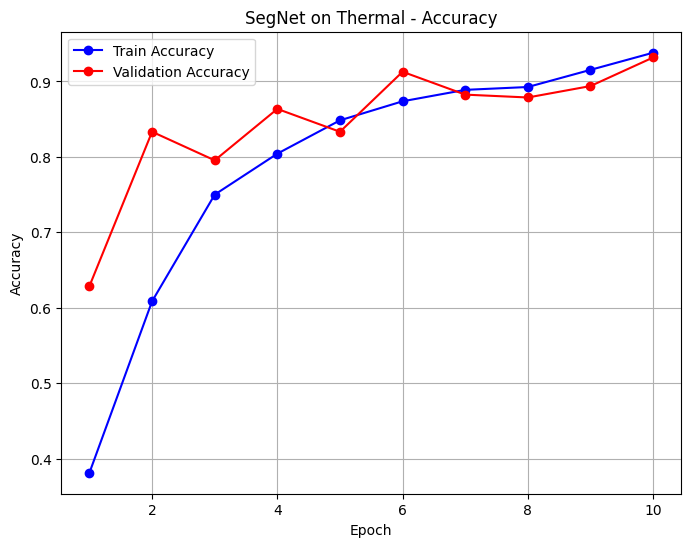

Test Accuracy: 0.9129


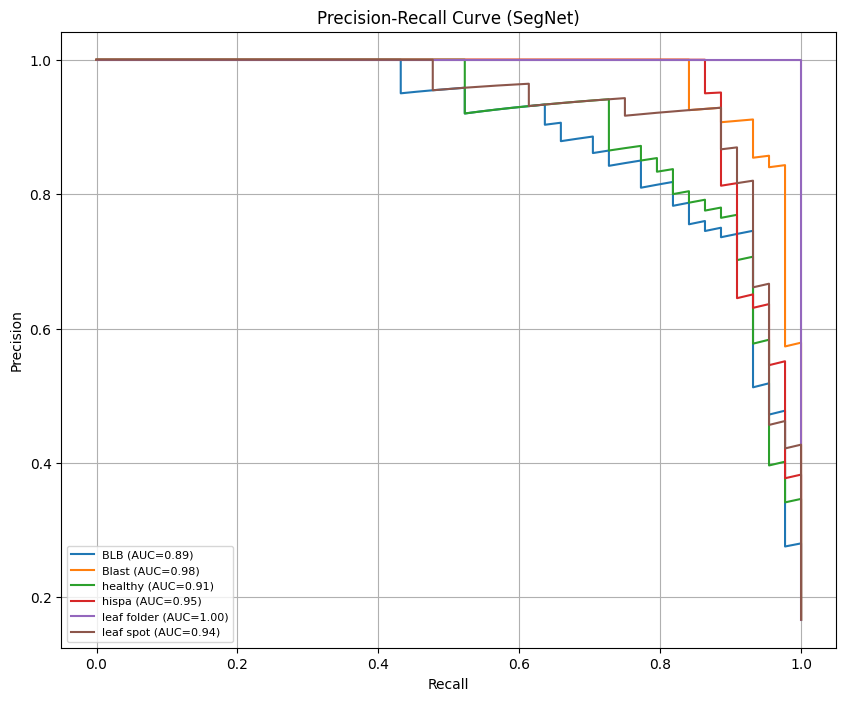

Final test accuracy for SegNet on Augmented Thermal: 0.9129



In [ ]:
import os
import copy
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# -----------------------------------------------------------------------------
# Global Settings
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.manual_seed(42)
np.random.seed(42)

# -----------------------------------------------------------------------------
# 1. Augmentations & Deterministic Transforms
# -----------------------------------------------------------------------------
class AlbumentationsTransform:
    """Wraps an Albumentations transform for PyTorch datasets."""
    def __init__(self, transform):
        self.transform = transform
    def __call__(self, image):
        image = np.array(image)
        augmented = self.transform(image=image)
        return augmented['image']

def get_albumentations_train_transforms():
    # Strong augmentation scheme for Thermal dataset.
    transform = A.Compose([
        A.Resize(256, 256),
        A.RandomResizedCrop(224, 224, scale=(0.8, 1.0), p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=20, p=0.5),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    return AlbumentationsTransform(transform)

def get_deterministic_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

# -----------------------------------------------------------------------------
# 2. Custom ImageFolder (with optional filtering)
# -----------------------------------------------------------------------------
class CustomImageFolder(datasets.ImageFolder):
    """
    Extends ImageFolder to allow dynamic transform updates and filtering.
    For the Thermal dataset, we restrict to the allowed classes.
    """
    def __init__(self, root, allowed_classes=None, transform=None):
        super().__init__(root, transform=transform)
        if allowed_classes is not None:
            allowed_set = set(allowed_classes)
            new_classes = [cls for cls in self.classes if cls in allowed_set]
            new_class_to_idx = {cls: i for i, cls in enumerate(new_classes)}
            new_samples = []
            for path, class_idx in self.samples:
                cls_name = self.classes[class_idx]
                if cls_name in allowed_set:
                    new_samples.append((path, new_class_to_idx[cls_name]))
            self.classes = new_classes
            self.class_to_idx = new_class_to_idx
            self.samples = new_samples
            self.targets = [s[1] for s in new_samples]
    def set_transform(self, transform):
        self.transform = transform

# -----------------------------------------------------------------------------
# 3. Stratified Splitting (60-20-20)
# -----------------------------------------------------------------------------
def stratified_split(dataset, train_size=0.6, val_size=0.2, test_size=0.2, random_state=42):
    targets = np.array(dataset.targets)
    indices = np.arange(len(dataset))
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_size), random_state=random_state)
    train_idx, temp_idx = next(sss1.split(indices, targets))
    temp_targets = targets[temp_idx]
    test_ratio = test_size / (test_size + val_size)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=random_state)
    val_idx, test_idx = next(sss2.split(temp_idx, temp_targets))
    val_idx = temp_idx[val_idx]
    test_idx = temp_idx[test_idx]
    return train_idx, val_idx, test_idx

# -----------------------------------------------------------------------------
# 4. DataLoader Function for Thermal Dataset (SegNet)
# -----------------------------------------------------------------------------
def get_dataloaders(dataset_path, batch_size=32):
    # IMPORTANT: Use the actual folder names from your dataset.
    allowed_classes = ["BLB", "Blast", "leaf spot", "leaf folder", "hispa", "healthy"]
    train_transform = get_albumentations_train_transforms()
    test_transform = get_deterministic_transform()
    
    full_dataset = CustomImageFolder(dataset_path, allowed_classes=allowed_classes, transform=train_transform)
    train_idx, val_idx, test_idx = stratified_split(full_dataset, train_size=0.6, val_size=0.2, test_size=0.2)
    
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(copy.deepcopy(full_dataset), val_idx)
    val_dataset.dataset.set_transform(test_transform)
    test_dataset = Subset(copy.deepcopy(full_dataset), test_idx)
    test_dataset.dataset.set_transform(test_transform)
    
    dataloaders = {
        "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True),
        "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True),
        "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    }
    class_names = full_dataset.classes
    print(f"Thermal dataset loaded: {len(full_dataset)} images, {len(class_names)} classes.")
    return dataloaders, class_names

# -----------------------------------------------------------------------------
# 5. SegNet-Inspired Model (using VGG16-BN)
# -----------------------------------------------------------------------------
class SegNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SegNetClassifier, self).__init__()
        vgg16_bn = models.vgg16_bn(pretrained=True)
        self.features = vgg16_bn.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# -----------------------------------------------------------------------------
# 6. Training, Evaluation, and Plotting
# -----------------------------------------------------------------------------
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, device='cpu', patience=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    early_stop_counter = 0
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += inputs.size(0)
            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
            
            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())
                scheduler.step(epoch_loss)
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print("Early stopping triggered!")
                        model.load_state_dict(best_model_wts)
                        elapsed = time.time() - since
                        print(f"Training complete in {int(elapsed//60)}m {int(elapsed%60)}s")
                        print(f"Best validation accuracy: {best_acc:.4f}")
                        return model, history
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print("-" * 50)
    elapsed = time.time() - since
    print(f"Training complete in {int(elapsed//60)}m {int(elapsed%60)}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)
    preds = np.argmax(all_outputs, axis=1)
    acc = accuracy_score(all_labels, preds)
    print(f"Test Accuracy: {acc:.4f}")
    return all_labels, all_outputs, acc

def plot_accuracy_curves(history, title="Accuracy vs Epochs"):
    epochs = range(1, len(history["train_acc"]) + 1)
    plt.figure(figsize=(8,6))
    plt.plot(epochs, history["train_acc"], 'bo-', label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], 'ro-', label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pr_curve(y_true, y_scores, class_names, model_name="SegNet"):
    from sklearn.preprocessing import label_binarize
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    plt.figure(figsize=(10,8))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{class_names[i]} (AUC={pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({model_name})")
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.show()

def run_experiment(dataset_path, num_epochs=10, batch_size=32):
    print(f"\n{'=' * 50}\nRunning experiment on Thermal dataset with SegNet.\n{'=' * 50}")
    dataloaders, class_names = get_dataloaders(dataset_path, batch_size=batch_size)
    num_classes = len(class_names)
    model = SegNetClassifier(num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    model, history = train_model(model, dataloaders, criterion, optimizer,
                                 num_epochs=num_epochs, device=device)
    plot_accuracy_curves(history, title="SegNet on Thermal - Accuracy")
    y_true, y_scores, test_acc = evaluate_model(model, dataloaders["test"], device=device)
    plot_pr_curve(y_true, y_scores, class_names, model_name="SegNet")
    return model, history, test_acc

# -----------------------------------------------------------------------------
# 7. Thermal Dataset Augmentation (Experiment 2)
# -----------------------------------------------------------------------------
def augment_thermal_dataset(input_path, output_path, target_count=220):
    """
    For each class folder in the Thermal dataset, if the number of images is below target_count,
    augment images using Albumentations and save the augmented images.
    """
    os.makedirs(output_path, exist_ok=True)
    augmentation = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(blur_limit=(3,7), p=0.3),
        A.RandomResizedCrop(224, 224, scale=(0.8,1.0), p=0.5)
    ])
    for label in os.listdir(input_path):
        label_path = os.path.join(input_path, label)
        if not os.path.isdir(label_path):
            continue
        out_label_path = os.path.join(output_path, label)
        os.makedirs(out_label_path, exist_ok=True)
        img_files = [f for f in os.listdir(label_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        count = len(img_files)
        # Copy original images if not already present.
        for f in img_files:
            src = os.path.join(label_path, f)
            dst = os.path.join(out_label_path, f)
            if not os.path.exists(dst):
                cv2.imwrite(dst, cv2.imread(src))
        while count < target_count:
            f = np.random.choice(img_files)
            img = cv2.imread(os.path.join(label_path, f))
            if img is None:
                continue
            aug_img = augmentation(image=img)['image']
            out_fname = f"aug_{count}.jpg"
            cv2.imwrite(os.path.join(out_label_path, out_fname), aug_img)
            count += 1
        print(f"Class {label}: augmented to {count} images.")

# -----------------------------------------------------------------------------
# 8. Main: Run Experiments for Thermal Dataset with SegNet
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # Update these paths as needed.
    thermal_dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"  # Original Thermal dataset
    thermal_augmented_path = "/kaggle/working/thermal_augmented_segnet"  # Directory for augmented images
    
    NUM_EPOCHS = 10
    BATCH_SIZE = 32
    
    # Experiment 1: Standard Training on Thermal Dataset
    print("\n***** Experiment 1: Standard Training *****")
    model_th, history_th, test_acc_th = run_experiment(thermal_dataset_path, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
    print(f"Final test accuracy for SegNet on Thermal: {test_acc_th:.4f}\n")
    
    # Experiment 2: Augmented Thermal Dataset
    print("\n***** Experiment 2: Augmented Thermal Dataset *****")
    print("Augmenting Thermal dataset to balance classes...")
    augment_thermal_dataset(thermal_dataset_path, thermal_augmented_path, target_count=220)
    model_th_aug, history_th_aug, test_acc_th_aug = run_experiment(thermal_augmented_path, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
    print(f"Final test accuracy for SegNet on Augmented Thermal: {test_acc_th_aug:.4f}\n")
